# This will test the mstar fine tuned tl

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import graphlearning as gl

import batch_active_learning as bal
import utils

EXPERIMENT_1_SAVE_PATH = "Experiment Results/Experiment 1/"
EXPERIMENT_2_SAVE_PATH = "Experiment Results/Experiment 2/"
EXPERIMENT_3_SAVE_PATH = "Experiment Results/Experiment 3/"
EXPERIMENT_4_SAVE_PATH = "Experiment Results/Experiment 4/"

EXPERIMENT_3_NUM_EXPERIMENTS = 50

def experiment_2_simple_plotter(x_dict, y_dict, dataset):
    _, ax1 = plt.subplots()

    ax1.set_xlabel("Number of Labeled Points")
    ax1.set_ylabel("Accuracy (%)")
    for this_key in bal.ACQUISITION_FUNCTIONS:
        ax1.plot(x_dict[this_key], y_dict[this_key], label=this_key)
    ax1.tick_params(axis="x")

    # Add SoTA
    if dataset != "mstar":
        if dataset == "open_sar_ship":
            sota_val = 78.15
        elif dataset == "fusar":
            sota_val = 86.69
        ax1.plot(
            x_dict["uc"],
            sota_val * np.ones_like(x_dict["uc"]),
            label="SoTA",
            linestyle="--",
        )

    ax1.legend()
    plt.show()
    return

In [2]:
def experiment_2(dataset, embedding, hardware_acceleration):
    assert dataset in utils.AVAILABLE_SAR_DATASETS, "Invalid dataset"
    assert embedding in utils.AVAILABLE_EMBEDDINGS, "Invalid embedding"

    # Perform embedding
    if embedding == "cnnvae":
        X, labels, knn_data, initial = utils.cnnvae(
            dataset, hardware_acceleration=hardware_acceleration
        )
    elif embedding == "zero_shot_tl":
        X, labels, knn_data, initial = utils.zero_shot_tl(
            dataset, hardware_acceleration=hardware_acceleration
        )
    else:
        X, labels, knn_data, initial = utils.fine_tuned_tl(
            dataset, hardware_acceleration=hardware_acceleration, num_epochs = 1
        )

    # Create graph objects
    W = gl.weightmatrix.knn(X, utils.KNN_NUM, kernel="gaussian", knn_data=knn_data)
    G = gl.graph(W)

    acc_dict = {}
    num_labels_dict = {}

    coreset = bal.coreset_dijkstras(
        G,
        rad=bal.DENSITY_RADIUS,
        data=X,
        initial=list(initial),
        density_info=(True, bal.DENSITY_RADIUS, 1),
        knn_data=knn_data,
    )

    num_new_samples = bal.MAX_NEW_SAMPLES_DICT[dataset] - len(coreset)

    for acq_fun in bal.ACQUISITION_FUNCTIONS:

        _, num_labels, acc_vals, _ = bal.batch_active_learning_experiment(
            X,
            labels,
            W,
            coreset,
            new_samples=num_new_samples,
            al_mtd="local_max",
            acq_fun=acq_fun,
            knn_data=knn_data,
        )

        num_labels_dict[acq_fun] = np.array(num_labels)
        acc_dict[acq_fun] = acc_vals

    ##Plot and save
    experiment_2_simple_plotter(num_labels_dict, acc_dict, dataset)

    ##Save numpy arrays and pickles
    new_save_path = EXPERIMENT_2_SAVE_PATH + "Pickles/" + dataset + "_" + embedding

    df_num_labels = pd.DataFrame.from_dict(num_labels_dict, orient="index")
    df_acc = pd.DataFrame.from_dict(acc_dict, orient="index")
    df_num_labels.to_pickle(new_save_path + "_labels_dict.pkl")
    df_acc.to_pickle(new_save_path + "_acc_dict.pkl")

    return num_labels_dict, acc_dict

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training model for 1 epochs
Training complete in 3m 48s
Best val Acc: 0.115926


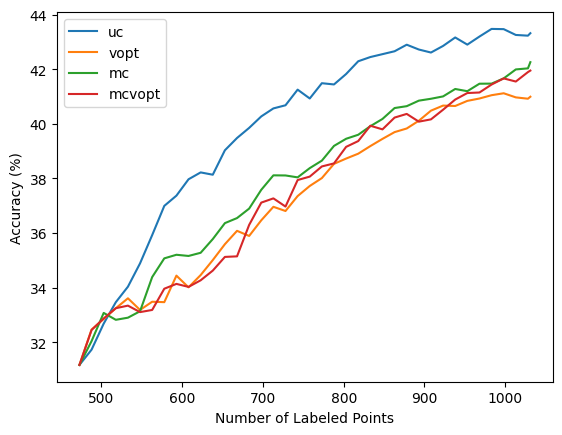

({'uc': array([ 473,  488,  503,  518,  533,  548,  563,  578,  593,  608,  623,
          638,  653,  668,  683,  698,  713,  728,  743,  758,  773,  788,
          803,  818,  833,  848,  863,  878,  893,  908,  923,  938,  953,
          968,  983,  998, 1013, 1028, 1031]),
  'vopt': array([ 473,  488,  503,  518,  533,  548,  563,  578,  593,  608,  623,
          638,  653,  668,  683,  698,  713,  728,  743,  758,  773,  788,
          803,  818,  833,  848,  863,  878,  893,  908,  923,  938,  953,
          968,  983,  998, 1013, 1028, 1031]),
  'mc': array([ 473,  488,  503,  518,  533,  548,  563,  578,  593,  608,  623,
          638,  653,  668,  683,  698,  713,  728,  743,  758,  773,  788,
          803,  818,  833,  848,  863,  878,  893,  908,  923,  938,  953,
          968,  983,  998, 1013, 1028, 1031]),
  'mcvopt': array([ 473,  488,  503,  518,  533,  548,  563,  578,  593,  608,  623,
          638,  653,  668,  683,  698,  713,  728,  743,  758,  773,  788,
    

In [3]:
experiment_2('mstar', 'fine_tuned_tl', hardware_acceleration=False)